In [72]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
from sklearn import metrics
import itertools
import numpy as np
from scipy.optimize import minimize

In [73]:
df = pd.read_csv("Dataset.csv", encoding = 'latin1')

In [74]:
new_df = df.drop(['OBJECTID1','File_tag','Provider','Date','Address_of_incident_4','CODE','NAME','ID_of__nearest__asset_5',
             'ID_of_nearest__polyphase__line_','Type_of_primary_asset__involved','Kind_of_fire_start_as_per_Claus',
             'Location__area_12','Fire__danger__rating_13','DNSP_record_number_14','OSIRIS___ESV__reference__number',
             'Fault__description_16','Overhead_conductors','BUFF_DIST','FOR_CODE','STATION_ID','CODE','NAME','WeatherStation',
             'Voltage_of_line_in_which__fire_','Network_categorisation_8','Phase_s__of__line_or__transform','FOR_TYPE','FOR_CAT'], axis = 1)

In [75]:
real_data_df = new_df.dropna()


In [76]:
real_data_df.head(3)

,DateOnly,Date_1,Time_2,Latitude_3,Longitude_3,Location_multiplier,Danger_multiplier,Product_of_multipliers,COVER,HEIGHT,FOREST,Elevation,Monthly Avg Rainfall,Monthly Mean Max Temperature,Monthly Mean Solar Exposure
1,24/01/2020,43854.00000,0.667361,-38.754127,143.667405,0.2,0.5,0.1,6,6,0,7.690627,129.4,26.9,21.8
3,20/02/2018,43151.69375,43151.693750,-38.669141,145.615890,0.2,1.0,0.2,6,6,0,25.977764,1.2,27,20.8
4,23/02/2018,43154.91458,43154.914580,-38.703816,145.819190,4.6,0.5,2.3,6,6,0,9.772949,1.2,27,20.8


In [77]:

real_data_df.shape

(1625, 15)

In [78]:
with_scaling_const = np.zeros(500)

no_scaling_const  = np.zeros(500)

for p in range(500):

    #Randomly select N records from the dataset
    random.seed(10)
    total_records = len(real_data_df.index)
    random.seed(10)
    imag_data_df = real_data_df.sample(n=total_records,replace=True)

    # create cases list
    g_factors = [0.2,1.0,4.6,19.8]
    t_factors = [0.1,0.2,0.5,1,2.0,3.5,5]
    cases = [g_factors,t_factors]
    cases_list = list(itertools.product(*cases))
    # data frame for cases real 

    df_cases_real = pd.DataFrame(cases_list, columns=['g_factors', 't_factors'])
    df_cases_real.insert((len(df_cases_real.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_real)))
    df_cases_real.insert((len(df_cases_real.columns)-1)+1 , 'count', 0)

    # data frame for cases imag 

    df_cases_imag = pd.DataFrame(cases_list, columns=['g_factors', 't_factors'])
    df_cases_imag.insert((len(df_cases_imag.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_imag)))
    df_cases_imag.insert((len(df_cases_imag.columns)-1)+1 , 'count', 0)

    # classify records according to case type Real 

    group_rows_real = pd.DataFrame(real_data_df.groupby(['Location_multiplier','Danger_multiplier']).size().reset_index(name='count'))
    # classify records according to case type Imag
    group_rows_imag = pd.DataFrame(imag_data_df.groupby(['Location_multiplier','Danger_multiplier']).size().reset_index(name='count'))

    # adding grouped rows to Real cases data frame
    for index_cases, row_cases in df_cases_real.iterrows():
        for index_records, row_records in group_rows_real.iterrows():
            if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
                df_cases_real.loc[index_cases, 'count'] =   row_records['count'] 

    #Calculate impact factor for Real Data frame  ### Imapact factor  (Cases*NumberofRecords) => C*N 

    df_cases_real["IRU_real"] = df_cases_real["g_factors"] * df_cases_real["t_factors"] * df_cases_real["count"] 

    # adding grouped rows to Imag cases data frame
    for index_cases, row_cases in df_cases_imag.iterrows():
        for index_records, row_records in group_rows_imag.iterrows():
            if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
                df_cases_imag.loc[index_cases, 'count'] =   row_records['count'] 


    #Calculate impact factor for Imag Data frame  ### Imapact factor  (Cases*NumberofRecords) => C*N

    df_cases_imag["IRU_imag"] = df_cases_imag["g_factors"] * df_cases_imag["t_factors"] * df_cases_imag["count"] 

    # Define where Cases Real and Cases Imag 
    
    c_real = np.zeros(shape=[28,]) # cases Real
    c_imag = np.zeros(shape=[28,]) # cases Imag
    c0 = np.zeros(shape=[28,1])
    c_real = df_cases_real[df_cases_real.columns[4]].to_numpy()
    c_imag = df_cases_imag[df_cases_imag.columns[4]].to_numpy()

    #c0 = np.abs(np.subtract(c_real,c_imag))
    c0 = np.subtract(c_real,c_imag)

    x_penalty = 25000
    # 1 M - [IRU(real) - IRU(img)] = 1M - (c_i * n_i (real) - c_i * n_i (img) ) * 25k 
    def objective(c0 , sign=-1.0):
        return  c0[0]+c0[1]+c0[2]+c0[3]+c0[4]+c0[5]+c0[6]+c0[7]+c0[8]+c0[9]+c0[10]+c0[11]+c0[12]+c0[13]+c0[14]+c0[15]+c0[16]+c0[17]+c0[18]+c0[19]+c0[20]+c0[21]+c0[22]+c0[23]+c0[24]+c0[25]+c0[26]+c0[27]

    # Contraints 

    def constraint1(c0):
        return c0[1] - c0[0]     # c2 - c1 >= 0

    def constraint2(c0):
        return c0[2] - c0[1]     # c3 - c2 >= 0 

    def constraint3(c0):
        return c0[3] - c0[2]     # c4 - c3 >= 0 

    def constraint4(c0):
        return c0[4] - c0[3]     # c5 - c4 >= 0

    def constraint5(c0):
        return c0[5] - c0[4]     # c6 - c5 >= 0

    def constraint6(c0):
        return c0[6] - c0[5]     # c7 - c6 >= 0

    def constraint7(c0):
        return c0[7] - c0[0]     # c8 - c7 >= 0  cant be because of row.

    def constraint8(c0):
        return c0[8] - c0[7]     # c9 - c8 >= 0

    def constraint9(c0):
        return c0[9] - c0[8]     # c10 - c9 >= 0

    def constraint10(c0):
        return c0[10] - c0[9]    # c11 - c10 >= 0

    def constraint11(c0):
        return c0[11] - c0[10]   # c12 - c11 >= 0

    def constraint12(c0):
        return c0[12] - c0[11]   # c13 - c12 >= 0

    def constraint13(c0):
        return c0[13] - c0[0]   # c14 - c1 >= 0  cant be because of row 

    def constraint14(c0):
        return c0[14] - c0[13]   # c15 - c14 >= 0

    def constraint15(c0):
        return c0[15] - c0[14]   # c16 - c15 >= 0

    def constraint16(c0):
        return c0[16] - c0[15]   # c17 - c16 >= 0

    def constraint17(c0):
        return c0[17] - c0[16]   # c18 - c17 >= 0

    def constraint18(c0):
        return c0[18] - c0[17]   # c19 - c18 >= 0

    def constraint19(c0):
        return c0[19] - c0[18]   # c20 - c19 >= 0

    def constraint20(c0):
        return c0[20] - c0[19]   # c21 - c20 >= 0

    def constraint21(c0):
        return c0[21] - c0[20]   # c21 - c7 >= 0

    def constraint22(c0):
        return c0[22] - c0[21]   # c23 - c22 >= 0

    def constraint23(c0):
        return c0[23] - c0[22]   # c24 - c23 >= 0

    def constraint24(c0):
        return c0[24] - c0[23]   # c25 - c24 >= 0

    def constraint25(c0):
        return c0[25] - c0[24]   # c26 - c25 >= 0

    def constraint26(c0):
        return c0[26] - c0[25]   # c27 - c26 >= 0

    def constraint27(c0):
        return c0[27] - c0[26]   # c28 - c27 >= 0

    def constraint28(c0):
        return (25000*(c0[0]+c0[1]+c0[2]+c0[3]+c0[4]+c0[5]+c0[6]+c0[7]+c0[8]+c0[9]+c0[10]+c0[11]+c0[12]+c0[13]+c0[14]+c0[15]+c0[16]+c0[17]+c0[18]+c0[19]+c0[20]+c0[21]+c0[22]+c0[23]+c0[24]+c0[25]+c0[26]+c0[27])) - 1000000   #C3- C2   c2 < c3


    con1 = {'type': 'ineq', 'fun': constraint1}
    con2 = {'type': 'ineq', 'fun': constraint2}
    con3 = {'type': 'ineq', 'fun': constraint3}
    con4 = {'type': 'ineq', 'fun': constraint4}
    con5 = {'type': 'ineq', 'fun': constraint5}
    con6 = {'type': 'ineq', 'fun': constraint6}
    con7 = {'type': 'ineq', 'fun': constraint7}
    con8 = {'type': 'ineq', 'fun': constraint8}
    con9 = {'type': 'ineq', 'fun': constraint9}
    con10 = {'type': 'ineq', 'fun': constraint10}
    con11 = {'type': 'ineq', 'fun': constraint11}
    con12 = {'type': 'ineq', 'fun': constraint12}
    con13 = {'type': 'ineq', 'fun': constraint13}
    con14 = {'type': 'ineq', 'fun': constraint14}
    con15 = {'type': 'ineq', 'fun': constraint15}
    con16 = {'type': 'ineq', 'fun': constraint16}
    con17 = {'type': 'ineq', 'fun': constraint17}
    con18 = {'type': 'ineq', 'fun': constraint18}
    con19 = {'type': 'ineq', 'fun': constraint19}
    con20 = {'type': 'ineq', 'fun': constraint20}
    con21 = {'type': 'ineq', 'fun': constraint21}
    con22 = {'type': 'ineq', 'fun': constraint22}
    con23 = {'type': 'ineq', 'fun': constraint23}
    con24 = {'type': 'ineq', 'fun': constraint24}
    con25 = {'type': 'ineq', 'fun': constraint25}
    con26 = {'type': 'ineq', 'fun': constraint26}
    con27 = {'type': 'ineq', 'fun': constraint27}
    con28 = {'type': 'ineq', 'fun': constraint28}

    #optimize

    cons = ([con1,con2,con3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,con14,con15,con16,con17,con18,con19,con20,con21,con22,con23,con24,con25,con26,con27,con28])

    # optimize
    b = (1.0,100000.0)
    bnds = (b,b, b, b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b)
    solution = minimize(objective,c0,method='SLSQP',constraints=cons)
    x = solution.x
    # dataframe with values of Cases

    df_cases_values = pd.DataFrame(x, columns=['values'])
    df_cases_values.insert((len(df_cases_values.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_values)))

    test_real_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
    test_real_df['count'] = df_cases_real['count']
    test_real_df['c'] = df_cases_values['values']
    test_real_df['IRU'] = test_real_df['count'] * test_real_df['c']
    sum_iru_real = np.sum(test_real_df['IRU'])


    test_imag_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
    test_imag_df['count'] = df_cases_imag['count']
    test_imag_df['c'] = df_cases_values['values']
    test_imag_df['IRU'] = test_imag_df['count'] * test_imag_df['c']
    sum_iru_imag = np.sum(test_imag_df['IRU'])


    # with scaling constant
    with_scaling_const[p] = ((np.abs((sum_iru_real - sum_iru_imag))/40) * 25000)
    # without scaling constant 
    no_scaling_const[p] = np.abs(sum_iru_real - sum_iru_imag) * 25000

 

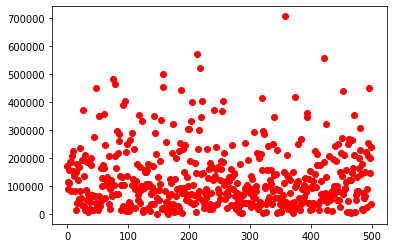

In [92]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(with_scaling_const,'ro')
plt.show()

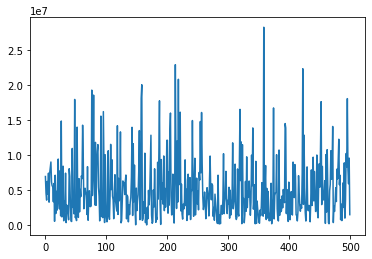

In [80]:


plt.plot(no_scaling_const)
plt.show()

In [95]:

np.amax(with_scaling_const)

706630.6547615814

In [81]:
# adding grouped rows to Real cases data frame
for index_cases, row_cases in df_cases_real.iterrows():
    for index_records, row_records in group_rows_real.iterrows():
        if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
            df_cases_real.loc[index_cases, 'count'] =   row_records['count'] 

#Calculate impact factor for Real Data frame  ### Imapact factor  (Cases*NumberofRecords) => C*N 

df_cases_real["IRU_real"] = df_cases_real["g_factors"] * df_cases_real["t_factors"] * df_cases_real["count"]  

df_cases_real

,g_factors,t_factors,case,count,IRU_real
0,0.2,0.1,1,238.0,4.76
1,0.2,0.2,2,234.0,9.36
2,0.2,0.5,3,262.0,26.20
3,0.2,1.0,4,122.0,24.40
4,0.2,2.0,5,39.0,15.60
5,0.2,3.5,6,16.0,11.20
6,0.2,5.0,7,0.0,0.00
7,1.0,0.1,8,78.0,7.80
8,1.0,0.2,9,86.0,17.20
9,1.0,0.5,10,106.0,53.00


In [82]:
# adding grouped rows to Imag cases data frame
for index_cases, row_cases in df_cases_imag.iterrows():
    for index_records, row_records in group_rows_imag.iterrows():
        if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
            df_cases_imag.loc[index_cases, 'count'] =   row_records['count'] 


#Calculate impact factor for Imag Data frame  ### Imapact factor  (Cases*NumberofRecords) => C*N

df_cases_imag["IRU_imag"] = df_cases_imag["g_factors"] * df_cases_imag["t_factors"] * df_cases_imag["count"] 

df_cases_imag


,g_factors,t_factors,case,count,IRU_imag
0,0.2,0.1,1,239.0,4.78
1,0.2,0.2,2,223.0,8.92
2,0.2,0.5,3,277.0,27.70
3,0.2,1.0,4,126.0,25.20
4,0.2,2.0,5,37.0,14.80
5,0.2,3.5,6,19.0,13.30
6,0.2,5.0,7,0.0,0.00
7,1.0,0.1,8,62.0,6.20
8,1.0,0.2,9,80.0,16.00
9,1.0,0.5,10,98.0,49.00


In [83]:
# get highest cases counts

# df_max_cases = df_cases.nlargest(3,columns=['count'])
# df_max_cases = df_max_cases.sort_values('case')
# df_max_cases

In [84]:
# Define where Cases Real and Cases Imag 
 
c_real = np.zeros(shape=[28,]) # cases Real
c_imag = np.zeros(shape=[28,]) # cases Imag
c0 = np.zeros(shape=[28,1])
c_real = df_cases_real[df_cases_real.columns[4]].to_numpy()
c_imag = df_cases_imag[df_cases_imag.columns[4]].to_numpy()

c0 = np.subtract(c_real,c_imag)
c0


array([-2.00e-02,  4.40e-01, -1.50e+00, -8.00e-01,  8.00e-01, -2.10e+00,
        0.00e+00,  1.60e+00,  1.20e+00,  4.00e+00, -1.60e+01,  2.00e+00,
        3.50e+00,  0.00e+00,  9.20e+00, -4.60e+00, -9.20e+00, -6.90e+01,
        2.76e+01, -3.22e+01,  0.00e+00,  1.98e+00,  3.96e+00, -2.97e+01,
       -3.96e+01,  0.00e+00,  0.00e+00,  0.00e+00])

In [85]:
 # Optimization Problem
 # Objective
import numpy as np
from scipy.optimize import minimize


# 1 M - [IRU(real) - IRU(img)] = 1M - (c_i * n_i (real) - c_i * n_i (img) ) * 25k 
def objective(c0 , sign=-1.0):
    return  c0[0]+c0[1]+c0[2]+c0[3]+c0[4]+c0[5]+c0[6]+c0[7]+c0[8]+c0[9]+c0[10]+c0[11]+c0[12]+c0[13]+c0[14]+c0[15]+c0[16]+c0[17]+c0[18]+c0[19]+c0[20]+c0[21]+c0[22]+c0[23]+c0[24]+c0[25]+c0[26]+c0[27]



def objective(x):
    return x[0]*x[3]*(x[0]+x[1]+x[2])+x[2]

def constraint1(x):
    return x[0]*x[1]*x[2]*x[3]-20.0

def constraint2(x):
    sum_eq = 40.0
    for i in range(4):
        sum_eq = sum_eq - x[i]**2
    return sum_eq

# initial guesses
c0 = np.zeros(shape=[28,1])

#
x_penalty = 25000

# show initial objective
print('Initial Objective: ' + str(objective(c0)))

# optimize
b = (1.0,5.0)
bnds = (b, b, b, b)
con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'eq', 'fun': constraint2}
cons = ([con1,con2])
solution = minimize(objective,x0,method='SLSQP',\
                    bounds=bnds,constraints=cons)
x = solution.x

#
print('Final Objective: ' + str(objective(x)))

# print solution
print('Solution')
print('c1 = ' + str(x[0]))
print('c2 = ' + str(x[1]))
print('c3 = ' + str(x[2]))

Initial Objective: [0.]


NameError: name 'x0' is not defined

In [ ]:
test_real_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
test_real_df['count'] = df_cases_real['count']
test_real_df['c'] = df_cases_values['values']
test_real_df['IRU'] = test_real_df['count'] * test_real_df['c']
sum_iru_real = np.sum(test_real_df['IRU'])


test_imag_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
test_imag_df['count'] = df_cases_imag['count']
test_imag_df['c'] = df_cases_values['values']
test_imag_df['IRU'] = test_imag_df['count'] * test_imag_df['c']
sum_iru_imag = np.sum(test_imag_df['IRU'])

np.abs(sum_iru_real - sum_iru_imag) * 25000

568096.2223961955

In [ ]:
sum_iru_real

2517.291330703348

In [ ]:
sum_iru_imag

2494.5674818075004

In [ ]:
np.abs(sum_iru_real - sum_iru_imag) * 25000

568096.2223961955

In [ ]:
test_real_df.head(20)

,count,c,IRU
0,238.0,1.000000,238.000000
1,234.0,4.742996,1109.861087
2,262.0,3.821155,1001.142511
3,122.0,1.379408,168.287733
4,39.0,NaN,NaN
5,16.0,NaN,NaN
6,0.0,NaN,NaN
7,78.0,NaN,NaN
8,86.0,NaN,NaN
9,106.0,NaN,NaN


In [ ]:
# Location Multiplier

# g.lbra.w=0.2
# g.hbra.w=1.0
# g.refcl.w=4.6,
# g.prf.w=19.8

# # T-factor weight allocation: No forecast (0.1), Low-Moderate (0.2), high (0.5), very high (1.0), severe (2.0), extreme (3.0), code red (5.0)

# Danger Multiplier

# t.noforecast.w=0.1
# t.low2mod.w=0.2
# t.high.w=0.5
# t.veryhigh.w=1.0
# t.severe.w=2.0
# t.extreme.w=3.5
# t.codered.w=5

import itertools
g_factors_names = ['g_lbra','g_hbra','g_refcl','g_prf']
t_factors_names = ['t_noforecast','t_low2mod','t_high','t_veryhigh','t_severe','t_extreme','t_codered']
cases_names = [g_factors_names,t_factors_names]
cases_list_names = list(itertools.product(*cases_names))
len(cases_list_names)
cases_list_names[0][0]

'g_lbra'

In [ ]:
zeroes = np.zeros(shape=[28,11]) 
df_case_matrix = pd.DataFrame(zeroes,columns=['g_lbra','g_hbra','g_refcl','g_prf','t_noforecast','t_low2mod','t_high','t_veryhigh','t_severe','t_extreme','t_codered'])

df_case_matrix

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:

i = 0
for g_fac,t_fac in cases_list_names:
    #print(g_fac,t_fac)
    df_case_matrix.loc[[i],[g_fac,t_fac]] = 1
    i = i+1
            
df_case_matrix

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
df_case_matrix['case']= df_cases_values['case']
df_case_matrix['values']= df_cases_values['values']
df_case_matrix

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered,case,values
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.742996
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.821155
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.379408
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN
7,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
9,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN


In [ ]:
df_matrix_max = df_case_matrix.nlargest(11,'values')
df_matrix_max

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered,case,values
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,4.742996
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,3.821155
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,1.379408
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000


In [ ]:
numpy_array = df_matrix_max.to_numpy()
A, b = numpy_array[:,0:11], numpy_array[:, 12]

A.shape


(4, 11)

In [ ]:
z= np.linalg.lstsq(A,b)


C:\Users\Waqar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [ ]:
z

(array([ 2.18871167e+00, -2.22044605e-16,  0.00000000e+00,  0.00000000e+00,
        -1.18871167e+00,  2.55428442e+00,  1.63244295e+00, -8.09304028e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 array([], dtype=float64),
 4,
 array([2.23606798, 1.        , 1.        , 1.        ]))